# Project Assignment B
Link to git repository: https://github.com/ongiboy/Cognitive-Social-Science

Group members:
* Christian Ong Hansen (s204109)
* Kavus Latifi Yaghin (s214601)
* Daniel Damkjær Ries (s214641)

Group member's contribution:
* Every task was made in collaboration by all members.

## 1. Motivation

* What is your dataset
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user’s experience?

## 2. Basic stats
* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats

### Data retrieval/cleaning

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures
import requests
import itertools
import networkx as nx
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from requests_futures.sessions import FuturesSession
import matplotlib.pyplot as plt
import ast
import numpy as np
from statistics import mode
import json

headers = {"accept": "application/json"}
api_key = "f5813332cb558d374cbcb057ea2fc48b"

In [ ]:
def movie_titles_and_IDs_from_actor_ID(actor_id, session):
    url = f"https://api.themoviedb.org/3/person/{actor_id}/movie_credits?api_key={api_key}"
    response = session.get(url)
    data = response.json()
    # Return the whole movie dictionary, not just the title
    return [movie['title'] for movie in data['cast']], [movie['id'] for movie in data['cast']]

In [ ]:
def fetch_page(page, session):
    url = f"https://api.themoviedb.org/3/person/popular?api_key={api_key}&page={page}"
    response = session.get(url)
    data = response.json()
    people = []
    for person in data['results']:
        person_url = f"https://api.themoviedb.org/3/person/{person['id']}?api_key={api_key}"
        person_response = session.get(person_url)
        person_data = person_response.json()
        people.append((person['name'], person['id'], person_data['gender'], person_data['birthday'], person_data['place_of_birth']))
    return people

with requests.Session() as session:
    session.headers.update(headers)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        pages = list(range(1, 251))
        fetch_page_with_session = partial(fetch_page, session=session)
        people = list(executor.map(fetch_page_with_session, pages))

all_people_names, all_people_ids, all_people_genders, all_people_birthdays, all_people_birthplaces = zip(*itertools.chain(*people))

In [ ]:
# Create a DataFrame with 'actors' column
df_actors = pd.DataFrame(all_people_names, columns=['actors'])

# Add 'ids', 'genders', and 'birthplaces' columns to the DataFrame
df_actors['actor_ids'] = all_people_ids
df_actors['genders'] = all_people_genders
df_actors['ages'] = all_people_birthdays # This is not the age, but the birthday
df_actors['birthplaces'] = all_people_birthplaces

# Change birthplaces so that it only contains the country (text after the last comma)
df_actors['birthplaces'] = df_actors['birthplaces'].str.split(',').str[-1]

# Change birthday to age
df_actors['ages'] = pd.to_datetime(df_actors['ages'], errors='coerce')
df_actors['ages'] = (pd.to_datetime('today') - df_actors['ages']).dt.days // 365

# Drop rows with missing values
df_actors.dropna(inplace=True)

# Drop duplicates
df_actors.drop_duplicates(subset='actors', inplace=True)
#reset index
df_actors.reset_index(drop=True, inplace=True)


In [ ]:
# Fetch movies for each actor and add them to 'movies' and 'movie_IDs' columns
with requests.Session() as session:
    session.headers.update(headers)
    movie_titles_and_ids_from_actor_ID_with_session = partial(movie_titles_and_IDs_from_actor_ID, session=session)
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        movies_and_ids = list(executor.map(movie_titles_and_ids_from_actor_ID_with_session, df_actors['actor_ids']))

# Add 'movies' column to df_actors
df_actors['movies'] = [x[0] for x in movies_and_ids]

# Flatten movies_and_ids into two separate lists
movies = [item for sublist in [x[0] for x in movies_and_ids] for item in sublist]
ids = [item for sublist in [x[1] for x in movies_and_ids] for item in sublist]

# Convert the lists into a list of dictionaries
movies_and_ids_dict = [{'movie': movie, 'movie_ID': id} for movie, id in zip(movies, ids)]

# Convert the list of dictionaries into a DataFrame
movies_df = pd.DataFrame(movies_and_ids_dict)
movies_df = movies_df.drop_duplicates()
movies_df.reset_index(drop=True, inplace=True)

In [ ]:
def fetch(session, url):
    future = session.get(url, headers=headers)
    return future

def fetch_all(urls):
    with FuturesSession() as session:
        futures = [fetch(session, url) for url in urls]
        responses = [future.result().json() for future in futures]
    return responses

In [ ]:
# Prepare the URLs
urls = [f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}" for id in movies_df["movie_ID"]]
print('urls are prepared')

# Fetch all responses
responses = fetch_all(urls)
print('all responses are fetched')

# Process the responses
for i, response in enumerate(responses):
    if i % 100 == 0:
        print(f"Processing response {i+1}/{len(responses)}")
    if isinstance(response, Exception):
        print(f"Error: {response}")
        continue  # Skip this response
    # Process the response here

# Initialize empty lists to store the data
ratings = []
popularities = []
genres = []
release_dates = []
abstracts = []

# Process the responses one by one
for data in tqdm(responses):
    ratings.append(data.get('vote_average'))
    popularities.append(data.get('popularity'))
    genres.append([genre['name'] for genre in data.get('genres', [])])
    release_dates.append(data.get('release_date'))
    abstracts.append(data.get('overview'))
    
# Assign the lists to the DataFrame columns
movies_df['rating'] = ratings
movies_df['popularity'] = popularities
movies_df['genres'] = genres
movies_df['release_date'] = release_dates
movies_df['abstract'] = abstracts

In [ ]:
# Drop duplicates
movies_df.drop_duplicates(subset='movie', inplace=True)

# Drop rows with missing values
movies_df.dropna(inplace=True)

# Remove rows with empty lists in 'genres' column
movies_df = movies_df[movies_df['genres'].apply(lambda x: len(x) > 0)]

# Remove rows with empty release dates
movies_df = movies_df[movies_df['release_date'].apply(lambda x: len(x) > 0)]

# Drop row if abstract is missing
movies_df = movies_df[movies_df['abstract'].apply(lambda x: len(x) > 0)]

# Drop row if rating is missing
movies_df = movies_df[movies_df['rating'].apply(lambda x: x > 0)]

# Drop row if popularity is missing
movies_df = movies_df[movies_df['popularity'].apply(lambda x: x > 0)]

# Reset index
movies_df.reset_index(drop=True, inplace=True)

In [ ]:
# Combine the two dataframes so that each actor is associated with the movies they have acted in
df_actors_filtered = df_actors.copy()
df_movies_filtered = movies_df.copy()
df_movies_filtered.rename(columns={'movie': 'movies'}, inplace=True)

df_actors_filtered = df_actors_filtered.explode('movies').reset_index(drop=True)

df_actors_movies = df_actors_filtered.merge(df_movies_filtered, on='movies', how='left')

# Remove all rows where the release date is before 2010
df_actors_movies = df_actors_movies[(df_actors_movies['release_date'] >= '2010-01-01') & (df_actors_movies['release_date'] <= '2024-04-16')]

# Collapse the the actors in the actor column so there is only one row per actor and the movies and movie_IDs are stored in lists
df_actors_filtered = df_actors_movies.groupby('actors').agg({'actor_ids': 'first',
                                                             'genders': 'first',
                                                             'birthplaces': 'first',
                                                             'ages': 'first',
                                                             'movies': list, 
                                                             'movie_ID': list}).reset_index()

df_movies_filtered = df_actors_movies.drop_duplicates(subset=['movies']).groupby('movies').agg({'movie_ID': 'first',
                                                                                               'rating': 'first',
                                                                                               'popularity': 'first',
                                                                                               'genres': 'first',
                                                                                               'release_date': 'first',
                                                                                               'abstract': 'first'}).reset_index()

Cleaning the birthplace column, to avoid having the same country spelled differently etc...

In [ ]:
import pycountry
import re

# Clean birthplace column in actor dataframe
len_bef_clean = len(df_actors_filtered['birthplaces'].unique())

country_names = [country.name for country in pycountry.countries]

def normalize_country_name(name):
    # strip name
    name = name.strip()
    # replace '.' with ''
    name = name.replace('.', '').replace(']', '')

    if "UK" in name or "İngiltere" in name:
        return "United Kingdom"
    try:
        # Try to get the country object
        country = pycountry.countries.get(name=name)
        if country is not None:
            # If the country object is found, return the official name
            return country.name
        else:
            # If the country object is not found, try to find it by its common name
            country = pycountry.countries.search_fuzzy(name)
            return country[0].name
    except LookupError:
        # Standardizing names
        for country_name in country_names:
            if country_name in name:
                name = country_name

        # Fixing abbreviations and wird instances
        if "Russia" in name:
            return "Russian Federation"
        elif "Türkiye" in name or "Turkey" in name:
            return "Türkiye"
        elif "USA" in name or " US" in name or "United States" in name:
            return "United States"
        elif "Korea" in name:
            return "Korea, Republic of"
        elif "Czech" in name:
            return "Czechia"
        # Hardcoded, could use package to translate, maybe not necessary, few occurences
        elif "TX" in name:
            return "United States"
        elif "Frankrike" in name:
            return "France"
        elif "Afrique du Sud" in name:
            return "South Africa"
        elif "Irlanda" in name:
            return "Ireland"
        elif "中国" in name or "中华民国" in name or "重庆" in name or "南京" in name:
            return "China"
        
        
        # Updating from old names
        if "now" in name:
            match = re.search(r'\[now (.*?)', name)
            if match:
                return match.group(1)

        # If the country is not found, return the original name
        return name

# Normalize the country names in the DataFrame
df_actors_filtered['birthplaces'] = df_actors_filtered['birthplaces'].apply(normalize_country_name)

len_aft_clean = len(df_actors_filtered['birthplaces'].unique())
print("length before cleaning", len_bef_clean)
print("length after cleaning", len_aft_clean)

In [ ]:
# Set all popularity scores above 100 to 100
df_movies_filtered['popularity'] = df_movies_filtered['popularity'].clip(upper=100)

In [ ]:
# Calculate the histogram
counts, bin_edges = np.histogram(df_movies_filtered['popularity'], bins=100)

# Add a small constant to counts to avoid log(0)
counts = counts + 1e-10

# Plot the histogram
plt.plot(bin_edges[:-1], counts)

# Set the scale of both axes to logarithmic
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
plt.hist(df_movies_filtered['popularity'], bins=100)
plt.show()

In [ ]:
# Plot the age distribution
df_actors_filtered['ages'].hist(bins=30, edgecolor='white')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.cm as cm

# Get the counts of each unique value in the 'birthplace' column
birthplace_counts = df_actors_filtered['birthplaces'].value_counts()

# Calculate the percentage of each birthplace out of the total number of actors
birthplace_percentages = (birthplace_counts / df_actors_filtered['birthplaces'].count()) * 100

# Get the top 5 birthplaces
top_5_birthplaces = birthplace_percentages[:10]

# Create a color map
colors = cm.rainbow(np.linspace(0, 1, len(top_5_birthplaces)))

# Create a bar plot of the top 5 birthplaces with different colors for each bar
top_5_birthplaces.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Top 10 Birthplaces of Actors')
plt.xlabel('Birthplace')
plt.ylabel('Percentage of Actors (%)')

plt.show()

print("The number of unique birthplaces:",len(df_actors_filtered['birthplaces'].unique()))
# Get the birthplaces with a count of 1
birthplaces_with_count_1 = birthplace_counts[birthplace_counts == 1]

print("Number of countries only associated with One actor in our dataset",len(birthplaces_with_count_1))

In [ ]:
# save the dataframes to csv files
df_actors_filtered.to_csv('data/actors.csv', index=False)
df_movies_filtered.to_csv('data/movies.csv', index=False)

### Creating the network

In [221]:
# load the dataframes from csv files
df_actors_filtered = pd.read_csv('data/actors.csv', converters={'movies': ast.literal_eval, 'movie_ID': ast.literal_eval})
df_movies_filtered = pd.read_csv('data/movies.csv', converters={'genres': ast.literal_eval})

In [261]:
# Step 1: Prepare the Data
movie_to_actors = defaultdict(list)

for _ , row in df_actors_filtered.iterrows():
    actor = row['actors']
    movies = row['movies']
    for movie in movies:
        movie_to_actors[movie].append(actor)

edges = defaultdict(int)
for actors in movie_to_actors.values():
    for pair in itertools.combinations(sorted(actors), 2):
        edges[pair] += 1

# Step 2: Create the Graph
G = nx.Graph()

# Add nodes with attributes
for _ , row in df_actors_filtered.iterrows():
    G.add_node(row['actors'], gender=row['genders'], age=row['ages'], birthplace=row['birthplaces'])

# Add edges with weights
for edge, weight in edges.items():

# YAHNI
    if weight >= 2:
        G.add_edge(*edge, weight=weight)

# Step 3: Analyze the Graph
degrees = dict(G.degree(weight='weight'))
most_connected_actors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

### Initial network analysis

In [ ]:
# Find number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

N = num_nodes
L = num_edges

##### Degrees and weights

In [262]:

# Compute node degrees
degrees = dict(G.degree())
weighted_degrees = dict(G.degree(weight='weight'))

# Compute the specificied values
average_degree = np.mean(list(degrees.values()))
median_degree = np.median(list(degrees.values()))
try:
    mode_degree = mode(list(degrees.values())) #Degree value that occurs with highest frequency among the nodes
except:
    mode_degree = "No unique mode"
min_degree = min(degrees.values())
max_degree = max(degrees.values())

# Same calculations but for STRENGTH (WEIGHTED DEGREE)
average_weighted_degree = np.mean(list(weighted_degrees.values()))
median_weighted_degree = np.median(list(weighted_degrees.values()))
try:
    mode_weighted_degree = mode(list(weighted_degrees.values()))
except:
    mode_weighted_degree = "No unique mode"
min_weighted_degree = min(weighted_degrees.values())
max_weighted_degree = max(weighted_degrees.values())

print("Degree Analysis:")
print(f"Average Degree: {average_degree}")
print(f"Median Degree: {median_degree}")
print(f"Mode Degree: {mode_degree}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")

print("\nWeighted Degree Analysis:")
print(f"Average Weighted Degree: {average_weighted_degree}")
print(f"Median Weighted Degree: {median_weighted_degree}")
print(f"Mode Weighted Degree: {mode_weighted_degree}")
print(f"Minimum Weighted Degree: {min_weighted_degree}")
print(f"Maximum Weighted Degree: {max_weighted_degree}")

Degree Analysis:
Average Degree: 10.218784048812378
Median Degree: 3.0
Mode Degree: 0
Minimum Degree: 0
Maximum Degree: 195

Weighted Degree Analysis:
Average Weighted Degree: 25.989540204837656
Median Weighted Degree: 6.0
Mode Weighted Degree: 0
Minimum Weighted Degree: 0
Maximum Weighted Degree: 596


In [263]:
# Sort the edges by weight in descending order
sorted_edges = sorted(G.edges.data(), key=lambda x: x[2]['weight'], reverse=True)

print("Top 10 most important edges:")
for i, edge in enumerate(sorted_edges[:10], start=1):
    print(f"Rank: {i}, Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")

print("\nTop 10 actors with the highest degree:")
for i, actor in enumerate(most_connected_actors[:10], start=1):
    print(f"Rank: {i}, Actor: {actor[0]}, Degree: {actor[1]}")

Top 10 most important edges:
Rank: 1, Edge: Frank Welker - Grey DeLisle, Weight: 46
Rank: 2, Edge: Adam Copeland - John Cena, Weight: 42
Rank: 3, Edge: Dwayne Johnson - John Cena, Weight: 34
Rank: 4, Edge: Grey DeLisle - Matthew Lillard, Weight: 34
Rank: 5, Edge: Frank Welker - Matthew Lillard, Weight: 33
Rank: 6, Edge: Dee Bradley Baker - Grey DeLisle, Weight: 30
Rank: 7, Edge: Frank Welker - Jeff Bennett, Weight: 30
Rank: 8, Edge: Grey DeLisle - Kevin Michael Richardson, Weight: 28
Rank: 9, Edge: Grey DeLisle - Tara Strong, Weight: 27
Rank: 10, Edge: Grey DeLisle - Jeff Bennett, Weight: 24

Top 10 actors with the highest degree:
Rank: 1, Actor: Grey DeLisle, Degree: 596
Rank: 2, Actor: Samuel L. Jackson, Degree: 576
Rank: 3, Actor: Stan Lee, Degree: 539
Rank: 4, Actor: Frank Welker, Degree: 515
Rank: 5, Actor: Tara Strong, Degree: 497
Rank: 6, Actor: Dee Bradley Baker, Degree: 496
Rank: 7, Actor: Benedict Cumberbatch, Degree: 404
Rank: 8, Actor: Scarlett Johansson, Degree: 393
Rank: 

These are the top ten actors who have participated the most together, as the weight of an edge represents the number of times two actors (nodes) have co-acted in movies together. 

In [264]:
# Compute the probability that makes the expected number of edges equal to the actual number of edges in the graph.
p = 2*L/(N*(N-1))
print("Prob:",p)

# Compute the natural logarithm of N
ln_N = np.log(N)

print("Natural logarithm of N:", ln_N, 
      f"\nAnd p: {p} > ln(N)/N: {ln_N/N}")

Number of nodes:  4589
Number of edges:  23447
Prob: 0.0022272851021822968
Natural logarithm of N: 8.431417414394833 
And p: 0.0022272851021822968 > ln(N)/N: 0.0018373103975582552


As the average degree is 10.22 and thus <k> > 1, and it is larger than ln(N) while p > ln(N)/N, the network must fall into the connected regime. It is therefore above the critical threshold. However, as we have thresholded the network by removing edges with an weight less than 2, it is not fully connected.

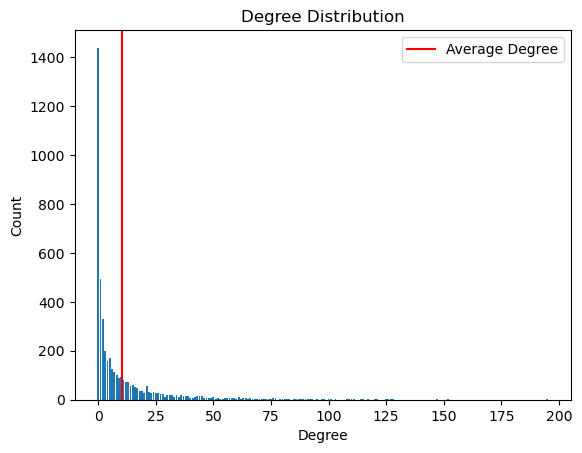

In [265]:
# Calculate degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # sort in ascending order
degree_count = nx.degree_histogram(G)

# Plot degree distribution
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.axvline(average_degree, color='r', linestyle='-', label='Average Degree')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.legend()
plt.show()


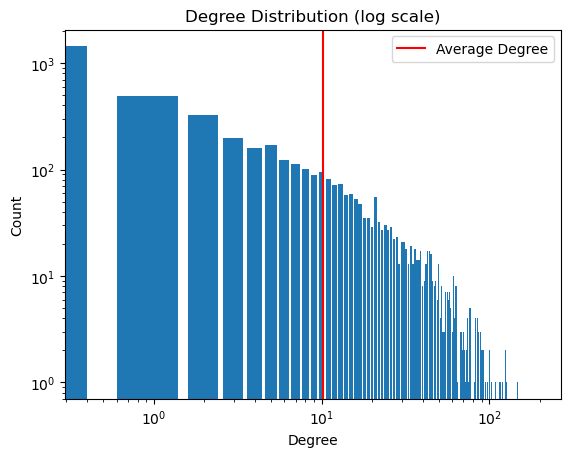

In [266]:
#make a log plot
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution (log scale)')
plt.axvline(average_degree, color='r', linestyle='-', label='Average Degree')
plt.legend()
plt.show()

In [267]:
# Plot with netwulf
import netwulf as nw

#nw.visualize(G)


### Network analysis

In [268]:
# Calculate the degree assortativity coefficient
degree_assortativity = nx.degree_assortativity_coefficient(G)

# Calculate the attribute assortativity coefficient
country_assortativity = nx.attribute_assortativity_coefficient(G, 'birthplace')

gender_assortativity = nx.attribute_assortativity_coefficient(G, 'gender')

# Calculate the numeric assortativity coefficient
age_assortativity = nx.numeric_assortativity_coefficient(G, 'age')


print(f"degree_assortativity: {degree_assortativity}, country_assortativity: {country_assortativity}, gender_assortativity: {gender_assortativity}")

print(f"age_assortativity: {age_assortativity}")

degree_assortativity: 0.14981105905637299, country_assortativity: 0.2888361442795611, gender_assortativity: 0.04136731628881341
age_assortativity: 0.3879416646689315


node to country assortativity: expected a higher value, but the litl lower value can be due to several reasons, desired nationality diversity, moving to different countries (living place) etc...

Note: TMBD very biased towards USA with their popular actors data that we have retrieved (over 50% of the total number of actors). Therefore a lot of the movies are american movies, and the actors from different countries may be more likely to 
It is also worth noting that 45 of the 109 unique birthplaces in our dataset is only associated with one actor, which is also a factor causing the unexpected low assortativity for the birthplace attribute. To fix this or make it more representative, we could webscrape from other websites to make a less biased dataset.

In [271]:
column = "birthplaces"
print(df_actors_filtered[column].value_counts())
print(len(df_actors_filtered[column].unique())) # the very old ages is due to actors included from older times aswell, where some are dead now.

birthplaces
United States         2498
United Kingdom         701
Canada                 244
Korea, Republic of     135
Australia               98
                      ... 
Panama                   1
Honduras                 1
French Polynesia         1
Bermuda                  1
Slovenia                 1
Name: count, Length: 109, dtype: int64
109


In [272]:
# Get the isolates
isolates = list(nx.isolates(G))

# Print the number of isolates
print(len(isolates))

1438


In [273]:
# x = df_movies_filtered['rating']
# x2 = df_movies_filtered['popularity']
# plt.scatter(x,x2) #ad

In [274]:
# Calculate the closeness centrality of the network
closeness_centrality = nx.closeness_centrality(G)

# Sort the actors according to the closeness centrality
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

In [275]:
# Find the 5 most central actors
most_central_actors = sorted_closeness_centrality[:10]
most_central_actors

[('Samuel L. Jackson', 0.27108768392518867),
 ('Stan Lee', 0.259887116040462),
 ('Tom Hanks', 0.2562298970269312),
 ('Benedict Cumberbatch', 0.2555673966775634),
 ('Robert De Niro', 0.2534454695745018),
 ('Bruce Willis', 0.2529513034139861),
 ('Matt Damon', 0.2519381473255456),
 ('Meryl Streep', 0.2511759917491735),
 ('Scarlett Johansson', 0.25090274335974494),
 ('Helen Mirren', 0.24954537098042437)]

In [276]:
# Calculate the eigenvector centrality of the network
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sort the scientists according to the eigenvector centrality
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

In [277]:
# Find the 5 most central actors
most_central_actors2 = sorted_eigenvector_centrality[:10]
most_central_actors2

[('Samuel L. Jackson', 0.17111097635837777),
 ('Stan Lee', 0.15895220209152428),
 ('Benedict Cumberbatch', 0.13931515600920477),
 ('Scarlett Johansson', 0.1371973642840203),
 ('Chris Pratt', 0.13419350860565232),
 ('Bradley Cooper', 0.1259503346726698),
 ('Paul Rudd', 0.12485065173004392),
 ('Tom Hiddleston', 0.12156945718827653),
 ('Chris Evans', 0.12108092425321709),
 ('Chris Hemsworth', 0.11702260396235827)]

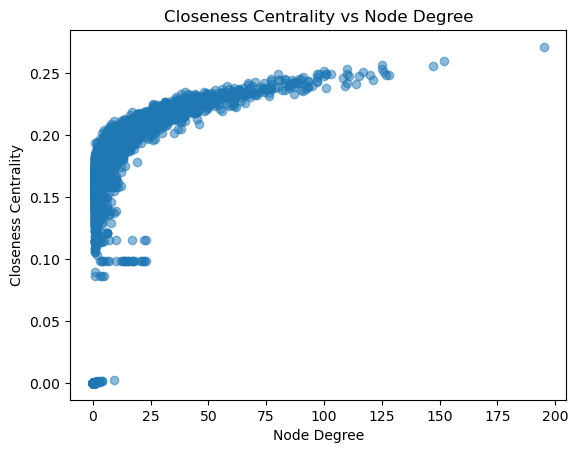

In [278]:
# Plot the closeness centrality vs node degree to see if there is a correlation
closeness_centrality_values = list(closeness_centrality.values())
degree_values = list(dict(G.degree()).values())

plt.scatter(degree_values, closeness_centrality_values, alpha=0.5)
plt.xlabel('Node Degree')
plt.ylabel('Closeness Centrality')
plt.title('Closeness Centrality vs Node Degree')
plt.show()

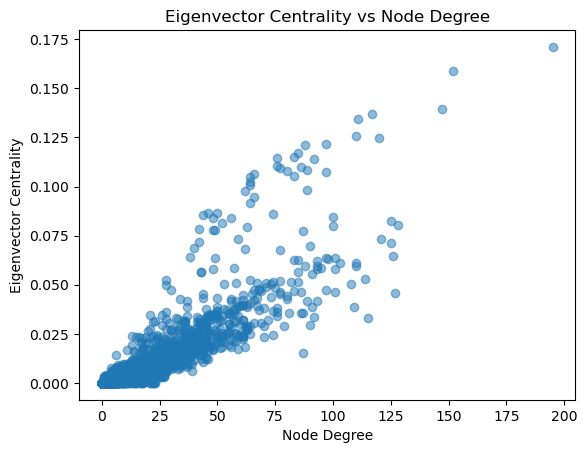

In [279]:
# Plot the eigenvector centrality vs node degree to see if there is a correlation
eigenvector_centrality_values = list(eigenvector_centrality.values())

plt.scatter(degree_values, eigenvector_centrality_values, alpha=0.5)
plt.xlabel('Node Degree')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Node Degree')
plt.show()

In [280]:
df_actors_filtered

actors  actor_ids  genders    birthplaces  ages  \
0            A.J. Cook      17236        1         Canada  45.0   
1             AJ Raval    2948828        1    Philippines  23.0   
2        Aaron Ashmore      90130        2         Canada  44.0   
3        Aaron Eckhart       6383        2  United States  56.0   
4         Aaron Haddad    1170008        2  United States  41.0   
...                ...        ...      ...            ...   ...   
4584    Úrsula Corberó    1042728        1          Spain  34.0   
4585  İbrahim Çelikkol     937348        2        Türkiye  42.0   
4586  İrem Helvacıoğlu    2004921        1        Germany  34.0   
4587       Şerif Sezer     142769        1        Türkiye  81.0   
4588               杨天翔    2185754        2          China  33.0   

                                                 movies  \
0     [Misconceptions, Bringing Ashley Home, Wer, Mo...   
1     [Paglaki Ko, Gusto Kong Maging Pornstar, Death...   
2     [The Shrine, I Put a Hit on You, Regression, S...   
3     [The Rum Diary, Rabbit Hole, Battle: Los Angel...   
4     [WWE Money In The Bank 2012, WWE Hell In A Cel...   
...                                                 ...   
4584  [Paranormal Xperience, Who Killed Bambi?, Off ...   
4585   [Conquest 1453, Sadece Sen, Intoxicated by Love]   
4586        [Eflâtun, Everything Is Beautiful with You]   
4587                           [Red Istanbul, The Lamb]   
4588  [White Snake, New Gods: Nezha Reborn, New Gods...   

                                               movie_ID  
0     [38598.0, 68387.0, 222461.0, 101669.0, 593843....  
1     [789474.0, 814082.0, 851274.0, 860306.0, 87348...  
2     [47763.0, 213200.0, 241257.0, 372490.0, 367543...  
3     [23514.0, 27585.0, 44943.0, 100241.0, 106021.0...  
4     [120120.0, 140486.0, 150735.0, 144244.0, 16350...  
...                                                 ...  
4584  [85438.0, 217414.0, 264729.0, 613486.0, 278736...  
4585                      [89584.0, 277934.0, 678856.0]  
4586                              [1036487.0, 529488.0]  
4587                               [443486.0, 255280.0]  
4588          [573699.0, 663558.0, 844075.0, 1089654.0]  

[4589 rows x 7 columns]

In [281]:
df_movies_filtered

movies   movie_ID  rating  \
0                                         "Eiyuu" Kaitai   557680.0   8.000   
1      "PSO" Series 15th Anniversary Concert "Sympath...   659076.0   6.000   
2      "Renjou" Keishichou Kyoukouhan-gakari Higuchi ...   932268.0   7.500   
3      "That's Awesome!": The Story of 'Dumb and Dumb...   336076.0   7.500   
4                                               "cherry"   263765.0   8.000   
...                                                  ...        ...     ...   
25798                                        Übermansion   639275.0  10.000   
25799                                        İnanç Odası   714907.0   4.000   
25800                              Ōmuro-ke dear sisters  1177096.0   6.500   
25801                          … But Film Is My Mistress   129487.0   6.273   
25802                     高橋みなみ卒業“148.5cmの見た夢”in 横浜スタジアム   929616.0   8.000   

       popularity                      genres release_date  \
0           1.302  [Animation, Drama, Comedy]   2016-11-23   
1           1.654                     [Music]   2016-03-24   
2           2.034      [Crime, Drama, Family]   2022-02-07   
3           2.819       [Documentary, Comedy]   2015-02-17   
4           7.685               [Documentary]   2014-03-20   
...           ...                         ...          ...   
25798       4.518         [Animation, Comedy]   2013-08-25   
25799       1.960           [Drama, Thriller]   2013-06-01   
25800      11.003         [Animation, Comedy]   2024-02-02   
25801       4.587               [Documentary]   2010-05-12   
25802       3.213                     [Music]   2016-07-20   

                                                abstract  
0      The story centers on a boy named Yamada Uro, a...  
1      Phantasy Star Online Series 15th Anniversary C...  
2      Kosuge, the president of a factory, is killed ...  
3      An expansive, five-part 45 minute making-of wi...  
4      Supreme presents, "cherry" a video by William ...  
...                                                  ...  
25798  A group of superheroes live in a mansion where...  
25799  4 youngsters in an illegal cell house are in p...  
25800  The first part of a spin-off of YuruYuri featu...  
25801  Guided by Liv Ullmann and with commentaries fr...  
25802  "Shuku Takahashi Minami Graduation "148.5cm no...  

[25803 rows x 7 columns]

### NLP TIME

In [307]:
import re
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from nltk.tokenize import MWETokenizer

stemmer = PorterStemmer()
# Define a function to tokenize and clean text
def tokenize_and_clean_text3(text, collocations): #takes text and dictionary of collocations
    # Exclude URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Exclude mathematical symbols and numbers
    text = re.sub(r'\b\d+\b', '', text)
    # Exclude punctuation and convert to lowercase
    text = re.sub(r'\W', ' ', text).lower()

    # Tokenize
    tokenizer = MWETokenizer(list(collocations.keys()))
    tokens = word_tokenize(text)
    
    tokens = tokenizer.tokenize(tokens)
    # stem
    tokens = [stemmer.stem(token) for token in tokens if token not in stopwords.words('english')]# TO REMOVE STOPWORDS 
    return tokens

In [305]:
# Assume abstracts is a list of movie abstracts
abstracts = df_movies_filtered['abstract'].copy().tolist()

# Tokenize the abstracts and remove stopwords
tokens = [word for abstract in abstracts for word in word_tokenize(abstract.lower()) if word not in stopwords.words('english')]

# Find bigram collocations
bigram_finder = BigramCollocationFinder.from_words(tokens)
bigram_measures = BigramAssocMeasures()

# Get the top 1000 bigrams by the Pointwise Mutual Information measure
top_bigrams = bigram_finder.nbest(bigram_measures.pmi, 1000)

# Convert the list of tuples into a dictionary
collocations = defaultdict(int)
for bigram in top_bigrams:
    collocations[bigram] += 1

In [308]:
df_movies_filtered['tokens'] = df_movies_filtered['abstract'].apply(lambda x: tokenize_and_clean_text3(x, collocations=collocations))

In [313]:
import community as community_louvain
# Compute the best partition using the Louvain method
partition = community_louvain.best_partition(G)

# Compute the modularity of this partition
modularity = community_louvain.modularity(partition, G)

print("Modularity found by Louvain algorithm:", modularity)

Modularity found by Louvain algorithm: 0.5310367320480541


In [314]:
# Calculate the number of communities and their sizes
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

num_communities = len(communities)
community_sizes = sorted([len(nodes) for nodes in communities.values()], reverse=True)

print("Number of communities:", num_communities)
print("Sizes of communities:", community_sizes)
# Check if the modularity is significantly different than 0
if abs(modularity) > 0.01:  # or any other threshold you consider significant
    print("The modularity is significantly different than 0.")
else:
    print("The modularity is not significantly different than 0.")

Number of communities: 1481
Sizes of communities: [477, 422, 374, 305, 241, 218, 210, 115, 92, 86, 81, 74, 69, 67, 60, 52, 45, 43, 30, 26, 11, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [315]:
# Create a DataFrame from the partition and degree information
communities_df = pd.DataFrame({
    'actors': list(G.nodes),
    'community': [partition[node] for node in G.nodes],
    'degree': [G.degree(node) for node in G.nodes]
})

In [316]:
# Merge actors_works_df with communities_df
df = pd.merge(df_actors_filtered, communities_df, on='actors')
df = df.drop(columns=["movies"]).explode('movie_ID')


# Merge with abstracts_df
df = pd.merge(df, df_movies_filtered, left_on='movie_ID', right_on='movie_ID')

# # Get abstract tokens for all communities
all_communities_abstracts = df.groupby('community')['tokens'].agg("sum").reset_index()

all_communities_abstracts.columns = ['Community', 'Abstract Tokens']

In [318]:
from collections import Counter
# The top 5 communities
top5_communities = communities_df['community'].value_counts().nlargest(5).index

# Filter dataframe for top 5 communities
top5_communities_abstracts = all_communities_abstracts[all_communities_abstracts['Community'].isin(top5_communities)]


top_terms = {}
for community in top5_communities:
    # Get the abstract tokens for the community
    abstract_tokens = top5_communities_abstracts[top5_communities_abstracts['Community'] == community]['Abstract Tokens'].values[0]
    # Get the TF of each term
    term_counts = Counter(abstract_tokens)
    # top 5 most frequent terms
    top_terms[community] = term_counts.most_common(5)

In [319]:
for item in top_terms.items():
    print(f"Community {item[0]}:")
    print(f"Top 5 terms: {item[1]}\n")

Community 17:
Top 5 terms: [('life', 1867), ('new', 1742), ('year', 1605), ('one', 1581), ('world', 1558)]

Community 7:
Top 5 terms: [('life', 1611), ('world', 1358), ('year', 1237), ('one', 1191), ('stori', 1142)]

Community 13:
Top 5 terms: [('life', 1612), ('find', 1504), ('new', 1409), ('one', 1372), ('famili', 1192)]

Community 6:
Top 5 terms: [('film', 1486), ('life', 1269), ('stori', 996), ('year', 982), ('one', 921)]

Community 9:
Top 5 terms: [('life', 993), ('new', 729), ('world', 689), ('one', 652), ('year', 634)]



In [329]:
import math
from tqdm import tqdm
# Get the top 9 communities and filter the abstracts for these communities
top9_communities = communities_df['community'].value_counts().nlargest(9).index
top9_communities_abstracts = all_communities_abstracts[all_communities_abstracts['Community'].isin(top9_communities)]

top_terms = {}
top_tfidf_terms = {}
all_tfidf_terms = {}

# (for less computational cost) get IDF for each term once and store the results
idf_dict = {}
for term in tqdm(set.union(*top9_communities_abstracts['Abstract Tokens'].apply(set))):
    idf_dict[term] = math.log(len(top9_communities_abstracts) / 
                              sum(term in abstract for abstract in top9_communities_abstracts['Abstract Tokens']))


for community in tqdm(top9_communities):
    # Get abstract tokens for the community
    abstract_tokens = top9_communities_abstracts[top9_communities_abstracts['Community'] == community]['Abstract Tokens'].values[0]
    
    # The top 10 TF terms
    term_counts = Counter(abstract_tokens)
    top_terms[community] = term_counts.most_common(10)


    tfidf = {}
    for term, count in term_counts.items():
        # TF for all terms in top 9 communities
        tf = count / len(abstract_tokens)

        # Get IDF from the precalculated dictionary
        idf = idf_dict[term]
        
        # TF-IDF for all terms in top 9 communities
        tfidf[term] = tf * idf

    all_tfidf_terms[community] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top 10 TF-IDF words
    top_tfidf_terms[community] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:10]

100%|██████████| 9/9 [00:00<00:00, 24.99it/s]


In [330]:
for item in top_tfidf_terms.items():
    print(f"Community {item[0]}:")
    print(f"Top 10 TF-IDF terms: {item[1]}\n")

Community 17:
Top 10 TF-IDF terms: [('bt', 0.0002535873443765253), ('silverman', 0.00018167451537422704), ('mal', 0.00018167451537422704), ('lineup', 0.00015365775828093172), ('bolton', 0.00014761054374155949), ('hubi', 0.00014508968456102114), ('drac', 0.00013990791011241324), ('hiccup', 0.0001316259158715983), ('stiller', 0.00012436258676658954), ('toothless', 0.00011175109693158671)]

Community 7:
Top 10 TF-IDF terms: [('voldemort', 0.000444679373859394), ('bilbo', 0.00026178705073980454), ('horcrux', 0.00021949566220146396), ('hogwart', 0.00019433286846824566), ('deathli', 0.0001928901273891653), ('perseu', 0.00018647844710232653), ('hermion', 0.00018195315324436533), ('nh', 0.0001748995816214211), ('worrick', 0.00017004125990971493), ('loro', 0.00015963320887379197)]

Community 13:
Top 10 TF-IDF terms: [('supermen', 0.00031545676532204476), ('expend', 0.0001596546023799666), ('demetri', 0.00014006999073632522), ('goldi', 0.0001364137363554788), ('damm', 0.00012788787783326138), ('

In [332]:
top9_communities_df = communities_df[communities_df['community'].isin(top9_communities)]

# Group by Community and Actor, and sum the Degree to get the total Degree for each Actor in each Community
grouped_df = top9_communities_df.groupby(['community', 'actors'])['degree'].sum().reset_index()

# Make new dataframe storing the top 3 actors by degree for each community
top_actors = grouped_df.groupby('community').apply(lambda x: x.nlargest(5, 'degree')).reset_index(drop=True)
top_actors

community                actors  degree
0           2          Frank Welker     127
1           2             Tom Hanks     125
2           2           Tara Strong     114
3           2     Dee Bradley Baker     109
4           2          Grey DeLisle      92
5           6          Meryl Streep     126
6           6        Robert De Niro     125
7           6      Steven Spielberg     108
8           6       Martin Scorsese     101
9           6        Dustin Hoffman      93
10          7         Ralph Fiennes     110
11          7        Cate Blanchett     103
12          7         Harrison Ford     101
13          7           Mark Hamill      98
14          7  Helena Bonham Carter      90
15          8     Samuel L. Jackson     195
16          8              Stan Lee     152
17          8  Benedict Cumberbatch     147
18          8    Scarlett Johansson     117
19          8           Chris Pratt     111
20          9            Matt Damon     100
21          9           Liam Neeson      97
22          9             Brad Pitt      83
23          9           Gary Oldman      80
24          9         Anne Hathaway      79
25         13           Danny Trejo     115
26         13          Bruce Willis     110
27         13           Kevin Smith      90
28         13          Eric Roberts      87
29         13        Rosario Dawson      86
30         17            Bill Hader     128
31         17          Maya Rudolph     121
32         17             Paul Rudd     120
33         17          James Franco     101
34         17          Will Ferrell     100
35         21           Ben Affleck      64
36         21             Gal Gadot      58
37         21            Diane Lane      55
38         21       Jesse Eisenberg      47
39         21       Michael Shannon      47
40        103       Octavia Spencer      42
41        103        Robert Forster      34
42        103           Naomi Watts      33
43        103           Zoë Kravitz      33
44        103            Aaron Paul      31

In [5]:
# load files for wordcloud
top_actors = pd.read_csv('data/top_actors.csv')

top9_communities = pd.read_csv('data/top9_communities.csv')

with open('data/all_tfidf_terms.json', 'r') as file:
    all_tfidf_terms = json.load(file)


Community 17:
Community 7:
Community 13:
Community 6:
Community 9:
Community 8:
Community 2:
Community 21:
Community 103:


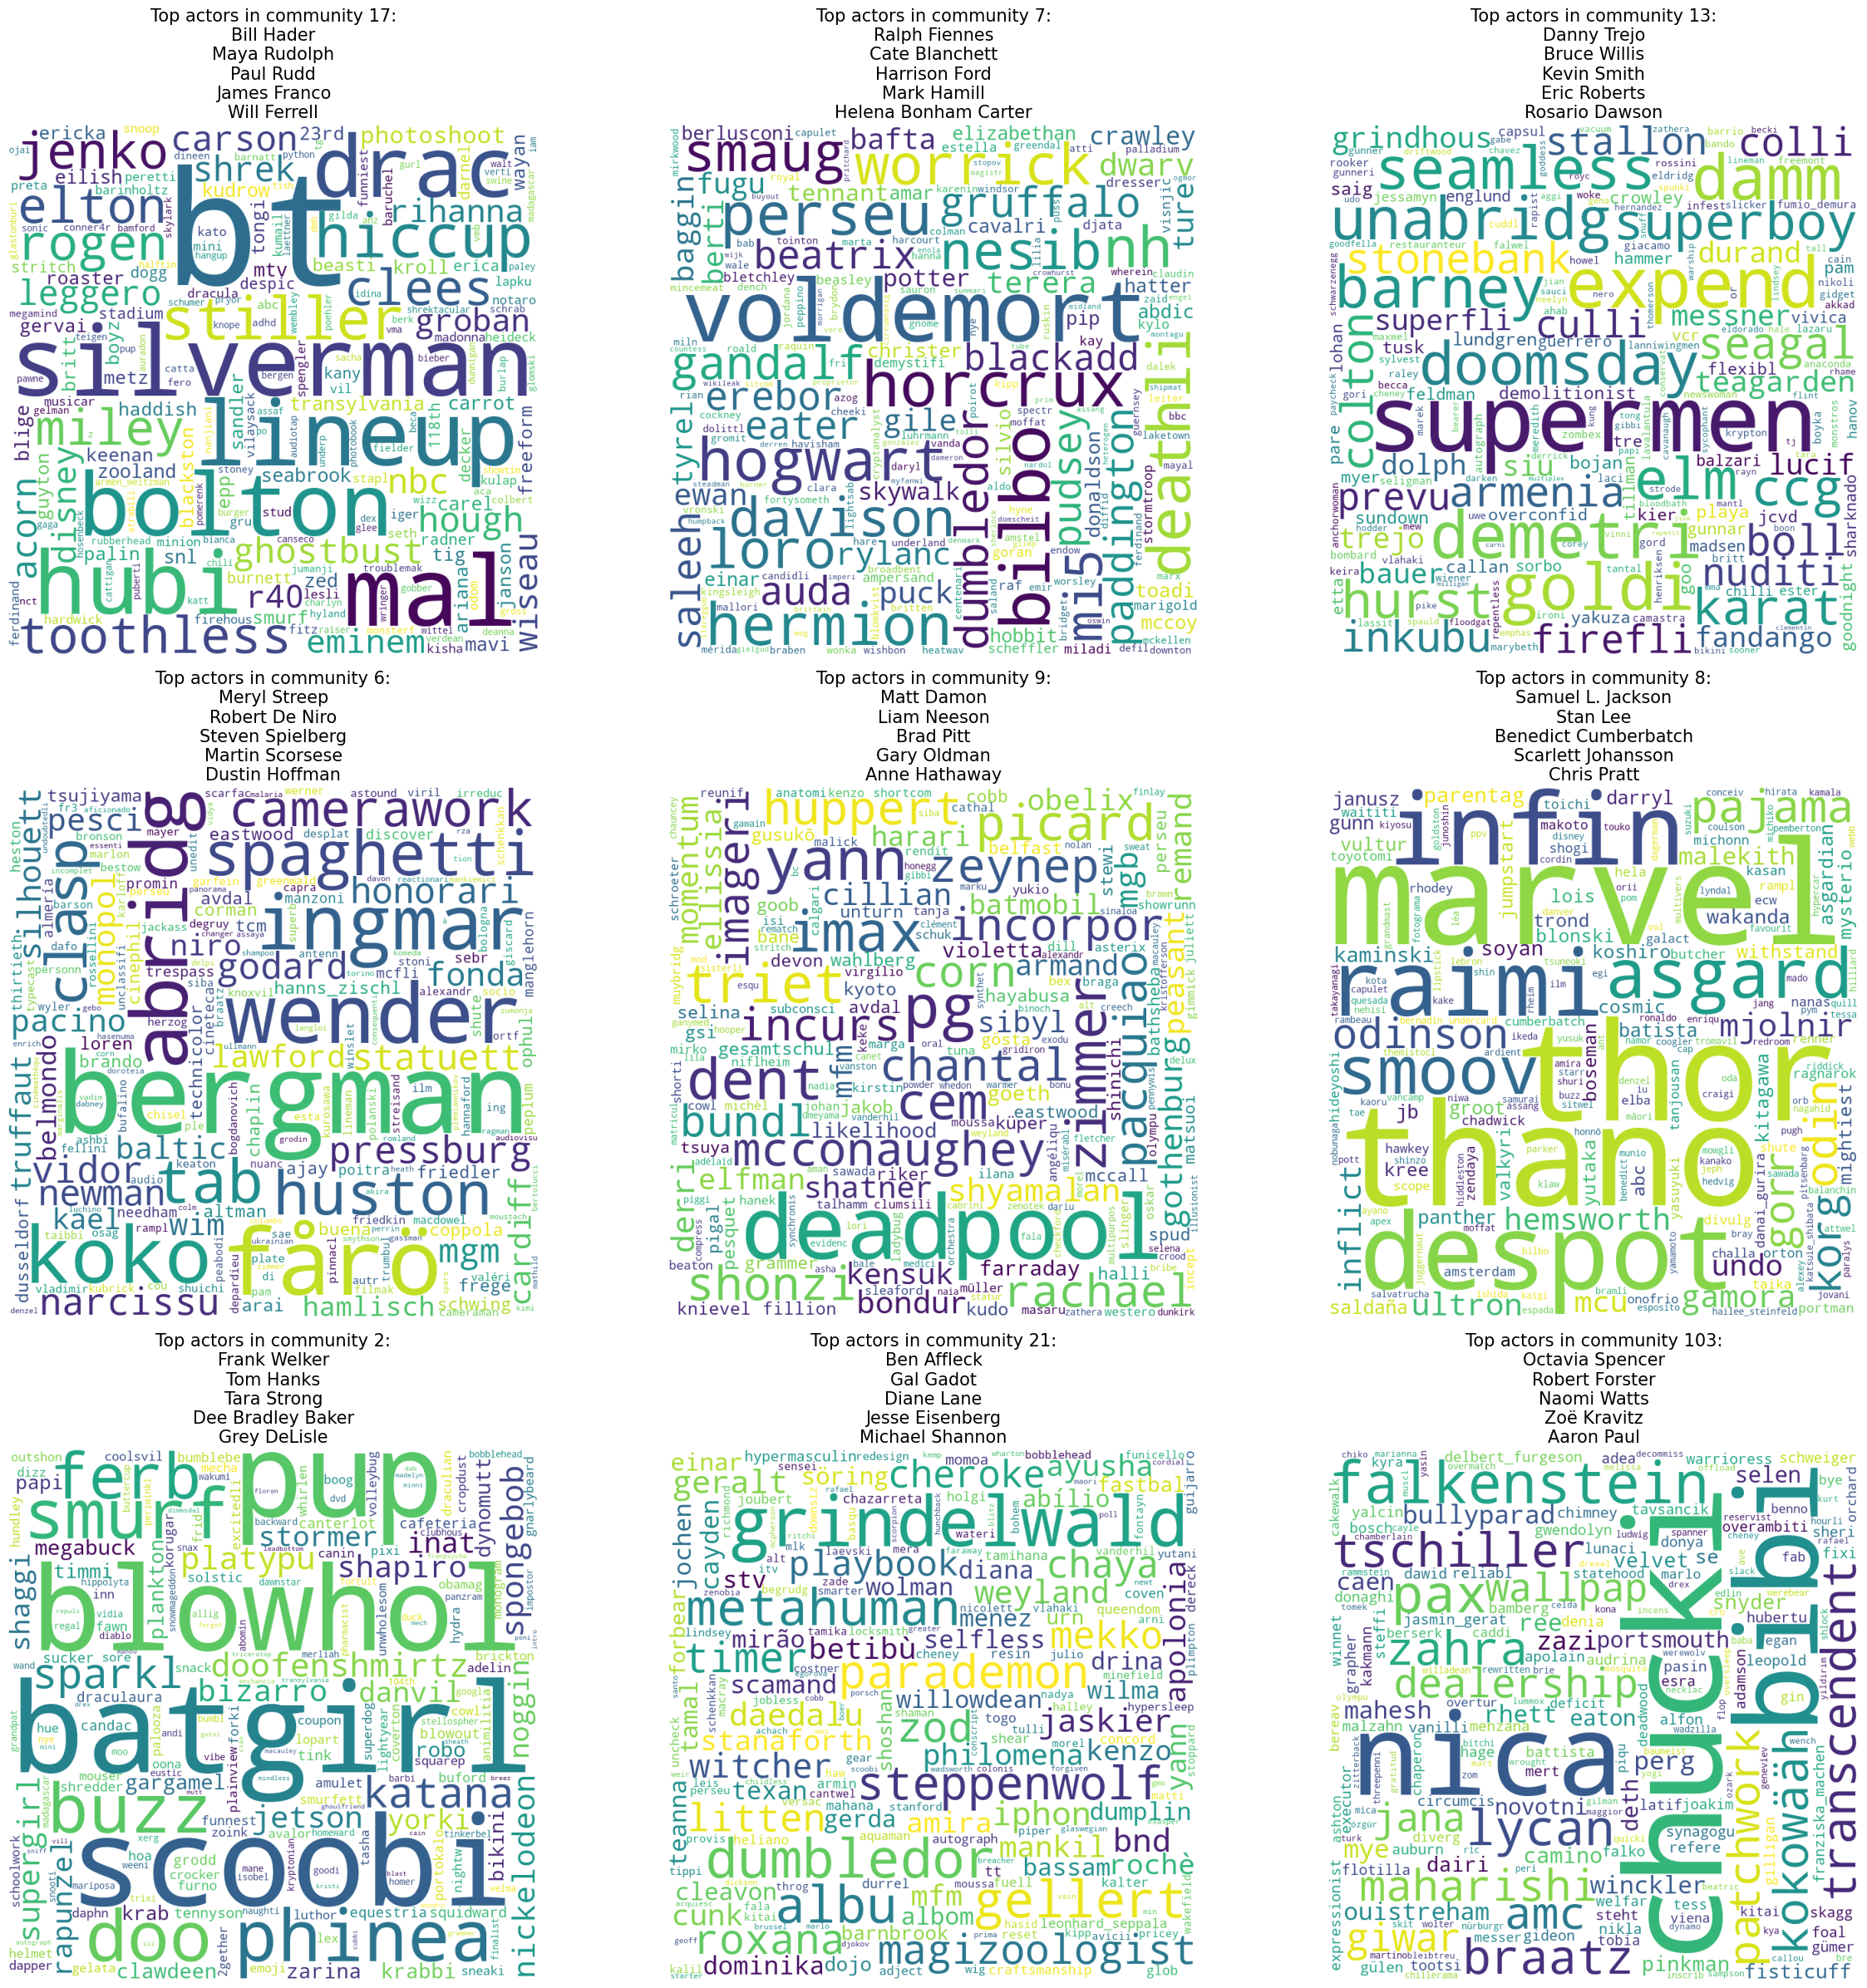

In [18]:
from wordcloud import WordCloud
fig, axs = plt.subplots(3, 3, figsize=(24, 24))

for i, community in enumerate(top9_communities["community"]):
    # Get the already calculated top TF-IDF terms for the community
    tfidf_terms = dict(all_tfidf_terms[str(community)])
    
    # Create the word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(tfidf_terms)
    
    # Subplot indices
    row = i // 3
    col = i % 3

    # Plot the word cloud
    axs[row, col].imshow(wordcloud)
    axs[row, col].axis("off")

    # Get the names of the top three actors in the community
    top_three_actors = top_actors[top_actors['community'] == community]['actors'].values
    # Create the title string with newlines
    title_string = "\n".join(top_three_actors)

    # Set title of subplot to the names of the top three actors, each on a new line
    axs[row, col].set_title(f"Top actors in community {community}:\n{title_string}", fontsize=15)

# Remove any extra subplots
for j in range(i+1, 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(pad = 1) 
plt.subplots_adjust(hspace = 0.25)  # Increase the hspace value
plt.show()

In [343]:
import json
import pandas as pd

# Save all_tfidf_terms as a JSON file in the data folder
with open('data/all_tfidf_terms.json', 'w') as f:
    json.dump(all_tfidf_terms, f)

# Save top9_communities as a CSV file in the data folder
pd.DataFrame(top9_communities, columns=['community']).to_csv('data/top9_communities.csv', index=False)

# Save top_actors as a CSV file in the data folder
top_actors.to_csv('data/top_actors.csv', index=False)